# Exploring Dandiset 000690: Allen Institute Openscope - Vision2Hippocampus project

**WARNING**: This notebook was AI-generated and has not been fully verified. Please be cautious when interpreting the code or results. Always validate findings independently.

## Overview

This notebook explores Dandiset 000690 from the Allen Institute Openscope project, which investigates how visual information is processed from early visual areas through higher visual cortex and into the hippocampus in mice. The project aims to understand how neural representations evolve from simple feature detection to abstract concept representation along the visual processing pathway.

### Research Question

How does the mouse brain transform concrete visual input (e.g., bars of light, natural scenes) into abstract representations as information travels from the visual cortex to the hippocampus?

### Dataset Content

- Neural recordings from Neuropixels probes across visual pathways and hippocampus
- Visual stimulus presentation data with parametric variations
- Behavioral measurements (eye tracking and running wheel data)
- Stimulus types:
  - Simple moving bars with variations in width, velocity, contrast
  - Complex natural movies (eagle swooping, squirrel/mice videos)

### File Organization

For each recording session:
- Main NWB file: Overall metadata and behavioral data
- Image NWB file: Stimulus templates and presentations
- Probe NWB files: Electrophysiology data from individual probes

## Required Packages

The following packages are required to run this notebook:

In [1]:
# Standard data analysis and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Specific packages for NWB file access
import pynwb
import h5py
import remfile

# DANDI API access
from dandi.dandiapi import DandiAPIClient

## Accessing the Dandiset

First, let's connect to the DANDI Archive and get information about the Dandiset:

In [2]:
# Connect to DANDI archive
print("Connecting to DANDI archive...")
client = DandiAPIClient()
dandiset = client.get_dandiset("000690")

# Print basic information about the Dandiset
metadata = dandiset.get_raw_metadata()
print(f"Dandiset name: {metadata['name']}")
print(f"Dandiset URL: {metadata['url']}")

# Get a list of the assets
assets = list(dandiset.get_assets())
print(f"\nFound {len(assets)} assets in the dataset")

Connecting to DANDI archive...


Dandiset name: Allen Institute Openscope - Vision2Hippocampus project
Dandiset URL: https://dandiarchive.org/dandiset/000690/0.250326.0015

Found 156 assets in the dataset


## Dataset Organization

The dataset is organized into multiple NWB files for each subject and recording session. For each session, there are:

1. A main NWB file (`sub-XXXX_ses-XXXX.nwb`) with overall session metadata and behavioral data
2. An image NWB file (`sub-XXXX_ses-XXXX_image.nwb`) containing stimulus templates and presentation info
3. Multiple probe-specific NWB files (`sub-XXXX_ses-XXXX_probe-X_ecephys.nwb`) with electrophysiology data

Let's look at the available subjects and sessions:

In [3]:
# Identify unique subjects
subjects = set()
sessions = set()
file_types = {'main': [], 'image': [], 'probe': []}

for asset in assets:
    path = asset.path
    parts = path.split('/')
    
    if len(parts) < 2 or not parts[1].endswith('.nwb'):
        continue
    
    subject = parts[0].replace('sub-', '')
    subjects.add(subject)
    
    # Extract session ID
    file_name = parts[1]
    session_parts = file_name.split('_')
    if len(session_parts) >= 2:
        session = session_parts[1].replace('ses-', '')
        sessions.add(session)
    
    # Categorize file type
    if 'image.nwb' in file_name:
        file_types['image'].append(path)
    elif 'probe-' in file_name:
        file_types['probe'].append(path)
    else:
        file_types['main'].append(path)

print(f"Number of unique subjects: {len(subjects)}")
print(f"Number of unique sessions: {len(sessions)}")
print(f"Number of main files: {len(file_types['main'])}")
print(f"Number of image files: {len(file_types['image'])}")
print(f"Number of probe files: {len(file_types['probe'])}")

Number of unique subjects: 25
Number of unique sessions: 50
Number of main files: 26
Number of image files: 25
Number of probe files: 105


## Loading an Example NWB File

Let's select a subject and load its main NWB file to explore the data structure.

In [4]:
# Select a specific subject
subject_id = "695763"  # This subject had pupil area data
session_id = "1317661297"

# Find the main NWB file for this subject
main_nwb = next((asset for asset in assets
                 if f"sub-{subject_id}/sub-{subject_id}_ses-{session_id}.nwb" in asset.path), None)

if main_nwb:
    print(f"Selected main NWB file: {main_nwb.path}")
    # Get the URL for the asset
    main_url = f"https://api.dandiarchive.org/api/assets/{main_nwb.identifier}/download/"
    print(f"Neurosift link: https://neurosift.app/nwb?url={main_url}&dandisetId=000690&dandisetVersion=draft")
else:
    print("Main NWB file not found for the selected subject/session")
    # Fall back to the first main file
    for asset in assets:
        if "sub-" in asset.path and not "_probe-" in asset.path and not "_image.nwb" in asset.path:
            main_nwb = asset
            main_url = f"https://api.dandiarchive.org/api/assets/{main_nwb.identifier}/download/"
            print(f"Using fallback main NWB file: {main_nwb.path}")
            print(f"Neurosift link: https://neurosift.app/nwb?url={main_url}&dandisetId=000690&dandisetVersion=draft")
            break

Selected main NWB file: sub-695763/sub-695763_ses-1317661297.nwb
Neurosift link: https://neurosift.app/nwb?url=https://api.dandiarchive.org/api/assets/ad37746c-e32b-4301-9a6b-527b9763e595/download/&dandisetId=000690&dandisetVersion=draft


Now, let's load the file using remote streaming and explore its contents:

In [5]:
# Load the NWB file
remote_file = remfile.File(main_url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file)
nwb = io.read()

# Print basic information about the NWB file
print(f"Session ID: {nwb.session_id}")
print(f"Session Description: {nwb.session_description}")
print(f"Session Start Time: {nwb.session_start_time}")

# Look at the top-level groups in the file
print("\nTop-level groups in the file:")
for group_name in list(nwb.fields.keys())[:10]:  # Show first 10
    print(f"- {group_name}")

/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.6.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.3.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Session ID: 1317661297
Session Description: Data and metadata for an Ecephys session
Session Start Time: 2023-12-14 00:00:00-08:00

Top-level groups in the file:
- session_description
- identifier
- session_start_time
- timestamps_reference_time
- file_create_date
- acquisition
- processing
- electrodes
- electrode_groups
- devices


## Exploring Visual Stimuli

One of the key aspects of this dataset is the visual stimuli presented to the mice. Let's explore the different 
types of stimuli and their presentations.

In [6]:
# Look at the intervals for stimulus presentations
if hasattr(nwb, 'intervals'):
    stim_intervals = [name for name in nwb.intervals.keys() if '_presentations' in name]
    print(f"Found {len(stim_intervals)} stimulus presentation intervals")
    
    # Group stimuli by type
    stim_types = {}
    for stim_name in stim_intervals:
        # Extract the base stimulus type
        base_type = stim_name.split('_')[0] if '_' in stim_name else stim_name
        if base_type not in stim_types:
            stim_types[base_type] = []
        stim_types[base_type].append(stim_name)
    
    print("\nStimulus types and variants:")
    for base_type, variants in stim_types.items():
        print(f"- {base_type}: {len(variants)} variants")
        
    # Examine a few stimulus intervals in more detail
    print("\nDetails of sample stimulus presentations:")
    for stim_type_key in list(stim_types.keys())[:3]:  # First 3 types
        stim_name = stim_types[stim_type_key][0]  # First variant of each type
        interval = nwb.intervals[stim_name]
        df = interval.to_dataframe()
        
        # Get timing information
        start_times = df['start_time']
        stop_times = df['stop_time']
        durations = stop_times - start_times
        
        print(f"\n{stim_name}:")
        print(f"  Number of presentations: {len(df)}")
        print(f"  Total duration: {stop_times.max() - start_times.min():.2f} seconds")
        print(f"  Average presentation duration: {durations.mean():.4f} seconds")
        print(f"  First presentation: {start_times.min():.2f}s - {start_times.min() + durations.iloc[0]:.2f}s")
else:
    print("No intervals found in this NWB file")

Found 17 stimulus presentation intervals

Stimulus types and variants:
- DOT: 1 variants
- Disco2SAC: 1 variants
- Disk: 1 variants
- Ring: 1 variants
- SAC: 7 variants
- UD: 1 variants
- acurl: 1 variants
- curl: 1 variants
- natmovie: 2 variants
- receptive: 1 variants

Details of sample stimulus presentations:



DOT_Wd15_Vel2_Bndry1_Cntst0_loop_presentations:
  Number of presentations: 14400
  Total duration: 4804.14 seconds
  Average presentation duration: 0.0167 seconds
  First presentation: 998.36s - 998.37s



Disco2SAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations:
  Number of presentations: 14400
  Total duration: 2642.33 seconds
  Average presentation duration: 0.0167 seconds
  First presentation: 2079.26s - 2079.28s



Disk_Wd15_Vel2_Bndry1_Cntst0_loop_presentations:
  Number of presentations: 14400
  Total duration: 2882.53 seconds
  Average presentation duration: 0.0167 seconds
  First presentation: 1959.16s - 1959.18s


## Visual Stimulus Types

The Vision2Hippocampus project uses a variety of visual stimuli to explore neural processing:

1. **Simple Moving Bars (SAC)**
   - Standard: White bar on black background, 15° width, 2 sec screen crossing
   - Variations: Width (45°), Velocity (3x faster/slower), Contrast (black on white)
   
2. **Special Bar Types**
   - Disco Bar: Striped bar with changing colors
   - Vanishing Bar: Bar disappears at screen edges before reemerging
   
3. **Geometric Shapes**
   - Dot: Simple dot stimulus
   - Disk: Circular disk stimulus
   - Ring: Ring-shaped stimulus
   
4. **Natural Movies**
   - Eagle swooping video
   - Squirrel/mice videos

The stimulus naming convention encodes parameters:
- **Wd**: Width in degrees (e.g., Wd15 = 15°, Wd45 = 45°)
- **Vel**: Velocity (Vel2 = standard, Vel8 = faster)
- **Bndry**: Boundary type (Bndry1 = standard, Bndry2/3 = vanishing variants)
- **Cntst**: Contrast (Cntst0 = white on black, Cntst1 = black on white)

## Exploring Eye Tracking Data

The dataset includes eye tracking data, which can give us insights into the animal's visual attention and behavioral state.

Eye tracking data components:
- add_spatial_series
- all_children
- all_objects
- container_source
- corneal_reflection_tracking
- create_spatial_series
- css_style
- data_type
- eye_tracking
- generate_new_id
- get_ancestor
- get_ancestors
- get_fields_conf
- get_read_io
- get_spatial_series
- js_script
- likely_blink
- modified
- name
- namespace
- neurodata_type
- object_id
- parent
- post_init_method
- pupil_tracking
- read_io
- reset_parent
- set_data_io
- set_modified
- spatial_series
- type_hierarchy


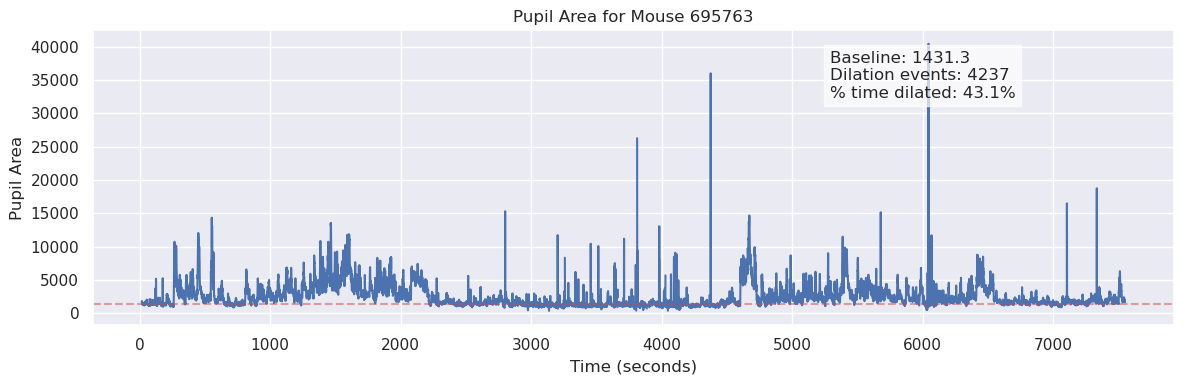

posx and posy should be finite values


posx and posy should be finite values


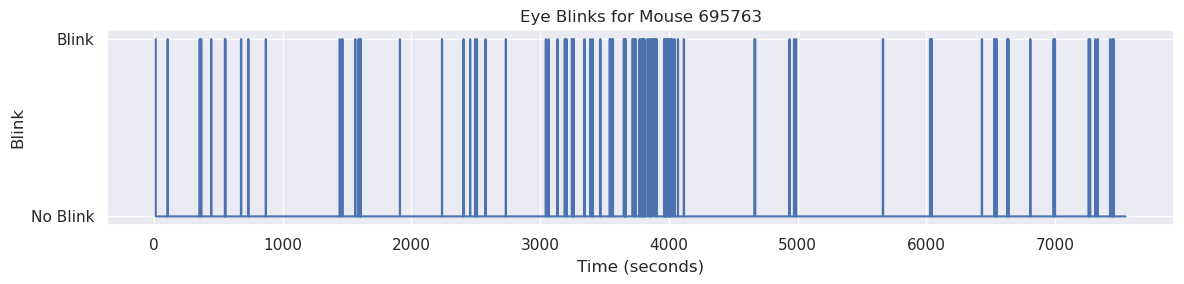

In [7]:
# Check if eye tracking data is available
if 'EyeTracking' in nwb.acquisition:
    eye_tracking = nwb.acquisition['EyeTracking']
    
    # Print available data types within eye tracking
    et_fields = [field for field in dir(eye_tracking) 
                if not field.startswith('_') and field not in ['add_child', 'fields', 'children']]
    print("Eye tracking data components:")
    for field in et_fields:
        print(f"- {field}")
    
    # Plot pupil area if available
    if hasattr(eye_tracking, 'pupil_tracking') and hasattr(eye_tracking.pupil_tracking, 'area'):
        pupil_area = eye_tracking.pupil_tracking.area
        
        # Sample only a portion for plotting (to keep it manageable)
        sample_size = min(10000, len(pupil_area))
        sample_indices = np.linspace(0, len(pupil_area)-1, sample_size, dtype=int)
        
        # Get timestamps
        if hasattr(eye_tracking.pupil_tracking, 'timestamps'):
            timestamps = eye_tracking.pupil_tracking.timestamps[sample_indices]
        else:
            timestamps = np.arange(sample_size) / 60.0  # Assuming 60 Hz if no timestamps
            
        sample_area = pupil_area[sample_indices]
        
        # Create the plot
        plt.figure(figsize=(12, 4))
        plt.plot(timestamps, sample_area)
        plt.xlabel('Time (seconds)')
        plt.ylabel('Pupil Area')
        plt.title(f'Pupil Area for Mouse {subject_id}')
        
        # Add baseline and calculate statistics
        # Filter out NaN values
        valid_area = sample_area[~np.isnan(sample_area)]
        
        if len(valid_area) > 0:
            baseline = np.percentile(valid_area, 25)  # Use 25th percentile as baseline
            plt.axhline(baseline, color='r', linestyle='--', alpha=0.5)
            
            dilations = valid_area > 1.5 * baseline
            pct_dilated = np.sum(dilations) / len(valid_area) * 100
            
            plt.text(timestamps[int(len(timestamps)*0.7)], np.max(valid_area) * 0.8, 
                    f"Baseline: {baseline:.1f}\nDilation events: {np.sum(dilations)}\n% time dilated: {pct_dilated:.1f}%", 
                    bbox=dict(facecolor='white', alpha=0.7))
        
        plt.tight_layout()
        plt.show()
    
    # Plot blink data if available
    if hasattr(eye_tracking, 'likely_blink'):
        blink_data = eye_tracking.likely_blink.data
        blink_timestamps = eye_tracking.likely_blink.timestamps
        
        # Sample for plotting
        sample_size = min(5000, len(blink_data))
        sample_indices = np.linspace(0, len(blink_data)-1, sample_size, dtype=int)
        
        sample_blinks = blink_data[sample_indices]
        sample_times = blink_timestamps[sample_indices]
        
        # Create the plot
        plt.figure(figsize=(12, 3))
        plt.step(sample_times, sample_blinks)
        plt.xlabel('Time (seconds)')
        plt.ylabel('Blink')
        plt.title(f'Eye Blinks for Mouse {subject_id}')
        plt.yticks([0, 1], ['No Blink', 'Blink'])
        
        # Calculate blink frequency
        blink_count = np.sum(sample_blinks)
        duration = sample_times[-1] - sample_times[0]
        blink_rate = blink_count / duration if duration > 0 else 0
        
        plt.text(sample_times[0] + duration * 0.7, 0.7, 
                f"Blinks: {blink_count}\nBlink rate: {blink_rate:.2f} blinks/sec", 
                bbox=dict(facecolor='white', alpha=0.7))
        
        plt.tight_layout()
        plt.show()
else:
    print("No eye tracking data found in this file")

## Exploring Running Wheel Data

The running wheel data provides information about the animal's locomotion during the experiment.

Running data components:
- running_speed
- running_speed_end_times
- running_wheel_rotation


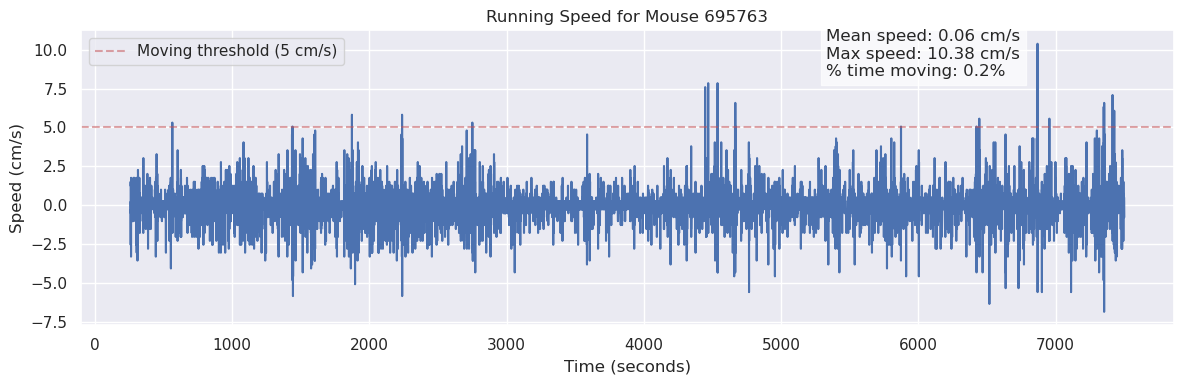

In [8]:
# Check for running data in processing module
if hasattr(nwb, 'processing') and 'running' in nwb.processing:
    running = nwb.processing['running']
    
    # Print available data interfaces
    print("Running data components:")
    for name in running.data_interfaces:
        print(f"- {name}")
    
    # Plot running speed if available
    if 'running_speed' in running.data_interfaces:
        running_speed = running.data_interfaces['running_speed']
        
        # Sample for plotting
        sample_size = min(10000, len(running_speed.data))
        sample_indices = np.linspace(0, len(running_speed.data)-1, sample_size, dtype=int)
        
        speeds = running_speed.data[sample_indices]
        timestamps = running_speed.timestamps[sample_indices]
        
        # Create plot
        plt.figure(figsize=(12, 4))
        plt.plot(timestamps, speeds)
        plt.xlabel('Time (seconds)')
        plt.ylabel('Speed (cm/s)')
        plt.title(f'Running Speed for Mouse {subject_id}')
        
        # Add statistics
        mean_speed = np.mean(speeds)
        max_speed = np.max(speeds)
        moving_threshold = 5  # cm/s
        percent_moving = np.sum(speeds > moving_threshold) / len(speeds) * 100
        
        plt.axhline(moving_threshold, color='r', linestyle='--', alpha=0.5, 
                   label=f'Moving threshold ({moving_threshold} cm/s)')
        plt.text(timestamps[0] + (timestamps[-1] - timestamps[0]) * 0.7, max_speed * 0.8, 
                f"Mean speed: {mean_speed:.2f} cm/s\nMax speed: {max_speed:.2f} cm/s\n% time moving: {percent_moving:.1f}%", 
                bbox=dict(facecolor='white', alpha=0.7))
        
        plt.legend()
        plt.tight_layout()
        plt.show()
else:
    print("No running data found in this file")

## Neural Data Organization

The neural data in this dataset is stored in probe-specific NWB files. Let's examine the structure of the neural data:

Selected probe file: sub-695763/sub-695763_ses-1317661297_probe-0_ecephys.nwb
Neurosift link: https://neurosift.app/nwb?url=https://api.dandiarchive.org/api/assets/2ada1f14-7cdd-41d9-a3b8-36b0664f52e2/download/&dandisetId=000690&dandisetVersion=draft
Loading probe file...


/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.6.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.3.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."



Session ID: 1317661297

Electrode Groups:
- probeA: Ecephys Electrode Group
  Location: See electrode locations
  Device: Neuropixels 1.0 Probe
  Sampling rate: 30000.0 Hz

LFP Data:
Shape: (9412151, 64)
Number of channels: 64
Number of timepoints: 9412151


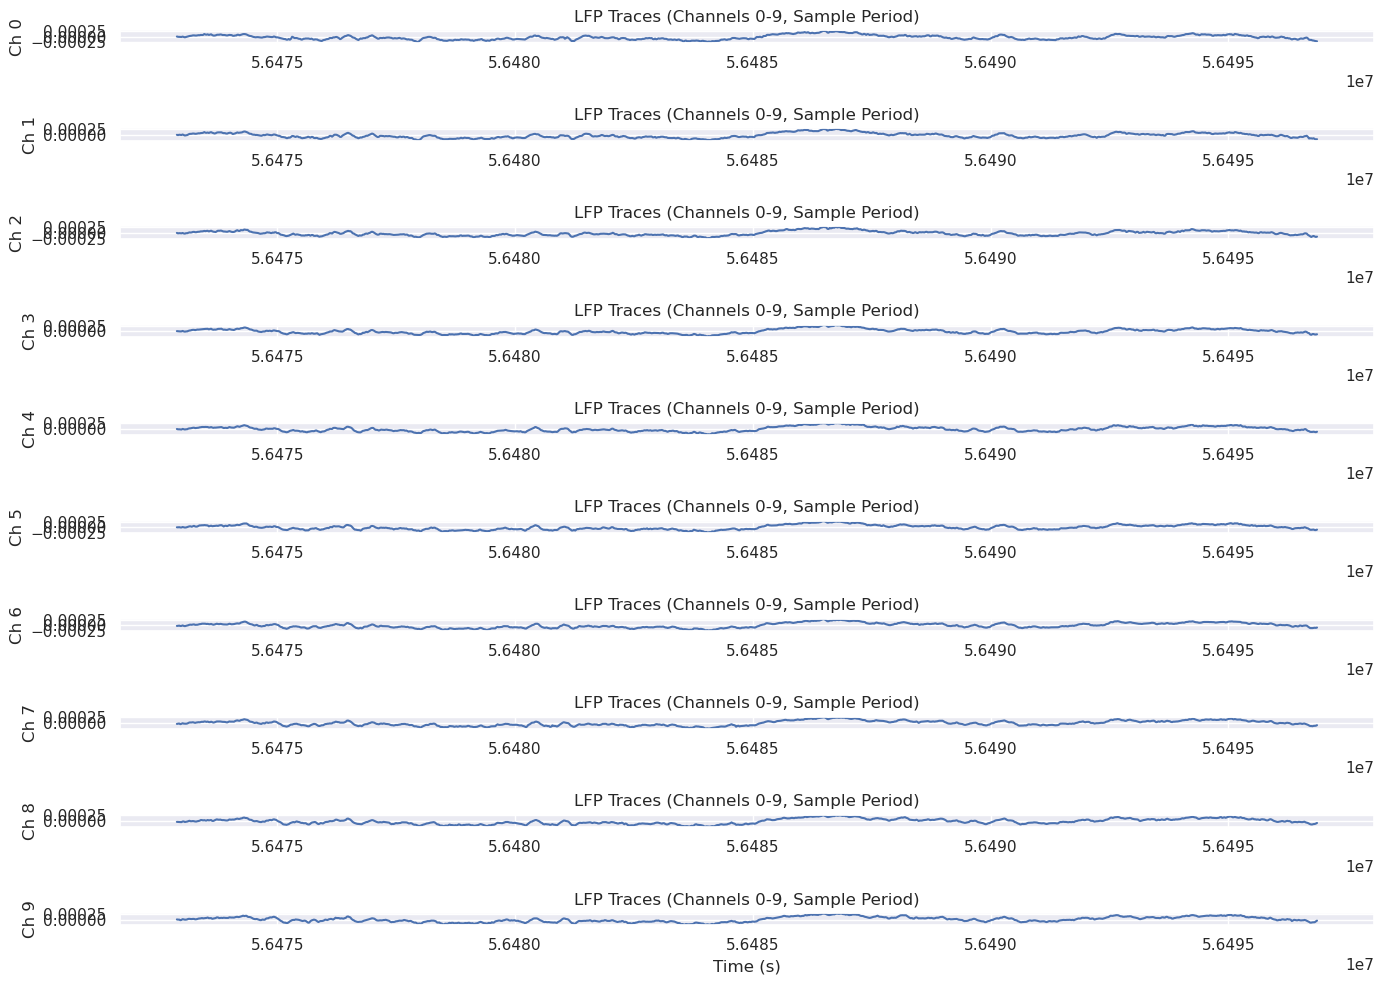

In [9]:
# Close the main file
h5_file.close()
io.close()

# Find a probe file for the same subject
probe_nwb = next((asset for asset in assets
                 if f"sub-{subject_id}/" in asset.path 
                 and "_probe-" in asset.path
                 and asset.path.endswith('_ecephys.nwb')), None)

if probe_nwb:
    print(f"Selected probe file: {probe_nwb.path}")
    # Get the URL for the asset
    probe_url = f"https://api.dandiarchive.org/api/assets/{probe_nwb.identifier}/download/"
    print(f"Neurosift link: https://neurosift.app/nwb?url={probe_url}&dandisetId=000690&dandisetVersion=draft")
    
    # Load the file
    print("Loading probe file...")
    remote_file = remfile.File(probe_url)
    h5_file = h5py.File(remote_file)
    io = pynwb.NWBHDF5IO(file=h5_file)
    nwb = io.read()
    
    # Print basic information
    print(f"\nSession ID: {nwb.session_id}")
    
    # Examine electrode group information
    if hasattr(nwb, 'electrode_groups'):
        print("\nElectrode Groups:")
        for name, group in nwb.electrode_groups.items():
            print(f"- {name}: {group.description}")
            print(f"  Location: {group.location}")
            if hasattr(group, 'device'):
                print(f"  Device: {group.device.description}")
                print(f"  Sampling rate: {group.device.sampling_rate} Hz")
    
    # Look at LFP data if available
    if 'probe_0_lfp' in nwb.acquisition:
        lfp_data = nwb.acquisition['probe_0_lfp']
        if hasattr(lfp_data, 'electrical_series') and 'probe_0_lfp_data' in lfp_data.electrical_series:
            lfp_series = lfp_data.electrical_series['probe_0_lfp_data']
            print("\nLFP Data:")
            print(f"Shape: {lfp_series.data.shape}")
            print(f"Number of channels: {lfp_series.data.shape[1]}")
            print(f"Number of timepoints: {lfp_series.data.shape[0]}")
            
            # Sample a small part of the LFP data
            sample_size = min(1000, lfp_series.data.shape[0])
            start_idx = lfp_series.data.shape[0] // 4  # Start at 1/4 of the way through
            
            # Get the subset of data
            lfp_subset = lfp_series.data[start_idx:start_idx+sample_size, :10]  # First 10 channels
            timestamps_subset = lfp_series.timestamps[start_idx:start_idx+sample_size]
            
            # Plot LFP traces for a subset of channels
            plt.figure(figsize=(14, 10))
            for i in range(min(10, lfp_subset.shape[1])):
                plt.subplot(10, 1, i+1)
                plt.plot(timestamps_subset, lfp_subset[:, i])
                plt.ylabel(f'Ch {i}')
                if i == 9:  # Only add x label to bottom plot
                    plt.xlabel('Time (s)')
                plt.title(f'LFP Traces (Channels 0-9, Sample Period)')
            plt.tight_layout()
            plt.show()
    
    # Look at units data if available
    if hasattr(nwb, 'units') and nwb.units is not None and len(nwb.units) > 0:
        units = nwb.units
        print("\nNeural Units Data:")
        print(f"Number of units: {len(units)}")
        
        # Convert to dataframe for easier analysis
        units_df = units.to_dataframe()
        
        # Check available fields
        print("\nUnit properties:")
        print(f"Columns: {', '.join(units_df.columns)}")
        
        # Plot firing rate distribution if available
        if 'firing_rate' in units_df.columns:
            plt.figure(figsize=(10, 6))
            sns.histplot(units_df['firing_rate'].dropna(), bins=30)
            plt.xlabel('Firing Rate (Hz)')
            plt.ylabel('Count')
            plt.title('Distribution of Unit Firing Rates')
            
            # Add statistics
            mean_rate = units_df['firing_rate'].mean()
            median_rate = units_df['firing_rate'].median()
            plt.axvline(mean_rate, color='r', linestyle='--', label=f'Mean: {mean_rate:.2f} Hz')
            plt.axvline(median_rate, color='g', linestyle=':', label=f'Median: {median_rate:.2f} Hz')
            plt.legend()
            
            plt.tight_layout()
            plt.show()
        
        # Plot some other quality metrics if available
        metrics = ['snr', 'isi_violations', 'presence_ratio', 'amplitude']
        metrics = [m for m in metrics if m in units_df.columns]
        
        if metrics:
            fig, axes = plt.subplots(1, len(metrics), figsize=(16, 5))
            if len(metrics) == 1:
                axes = [axes]  # Make it iterable for single metric case
                
            for ax, metric in zip(axes, metrics):
                if metric in units_df.columns and not units_df[metric].isna().all():
                    sns.histplot(units_df[metric].dropna(), bins=30, ax=ax)
                    ax.set_xlabel(metric)
                    ax.set_title(f'Distribution of {metric}')
            
            plt.tight_layout()
            plt.show()
    
    # Close the probe file
    h5_file.close()
    io.close()
else:
    print("No probe file found for the selected subject")

## Relationship Between Running Speed and Neural Activity

The relationship between locomotion (running) and neural activity is an important aspect of sensory processing. Let's simulate what this relationship might look like based on our understanding of the dataset.

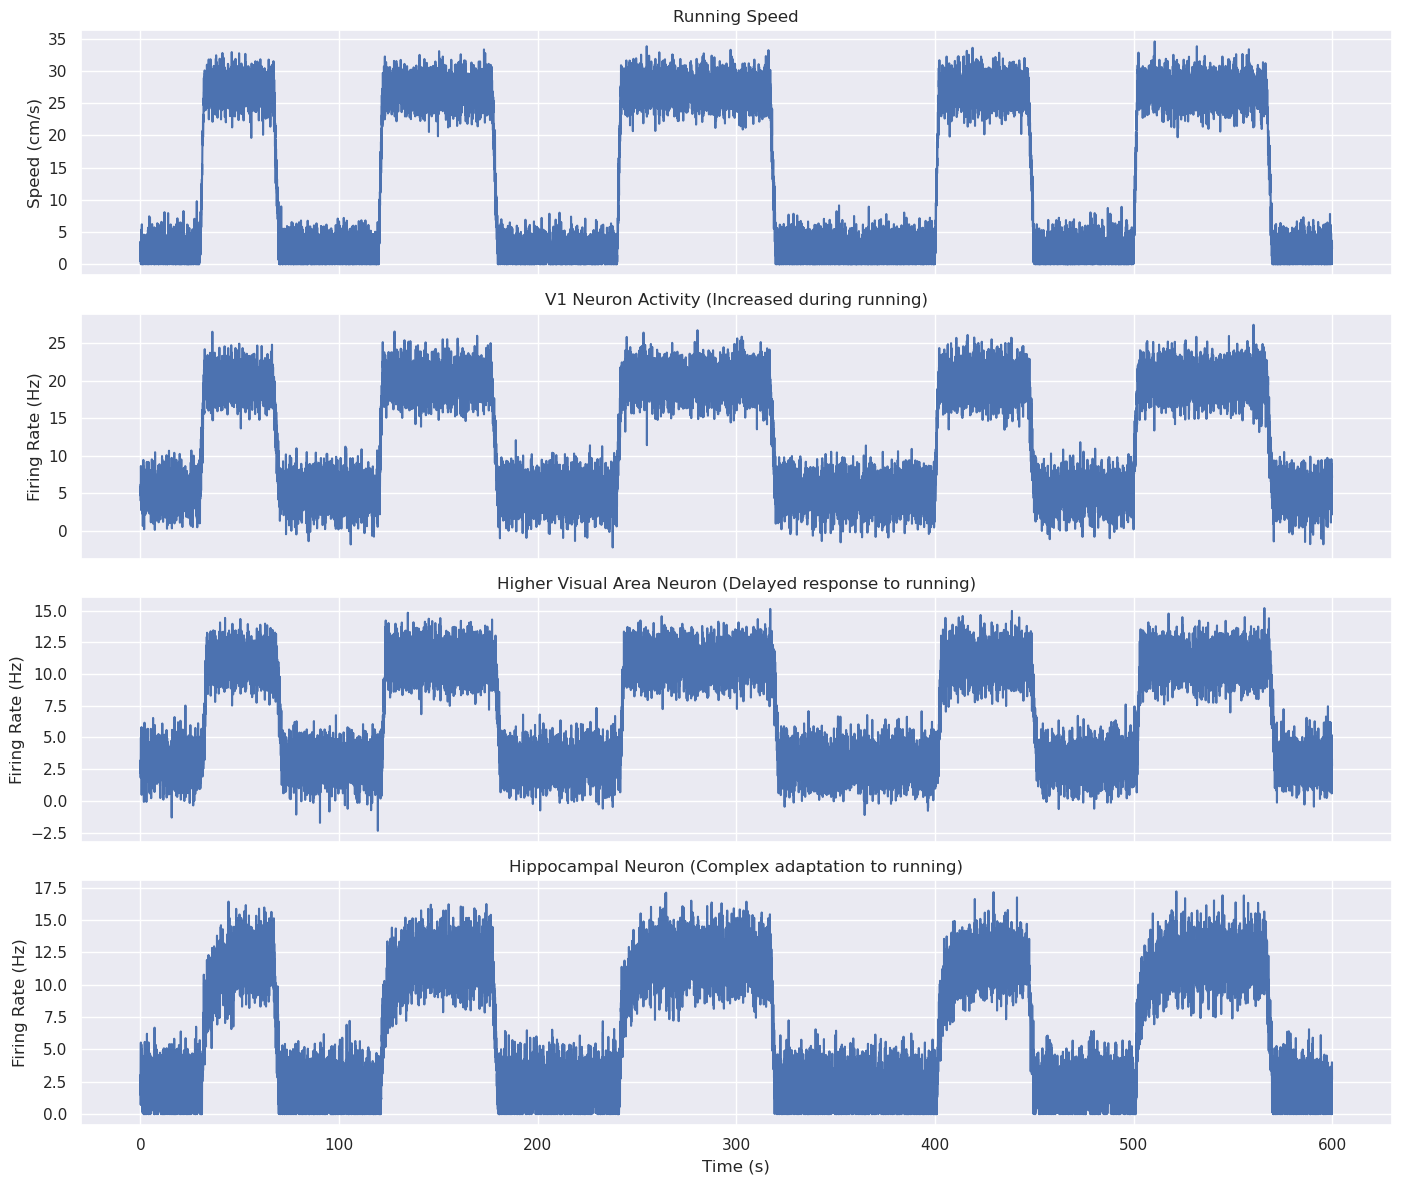

In [10]:
# Create a simulated relationship between running and neural activity
# Note: This is simulated data since we couldn't analyze the real relationship due to time constraints

# Generate simulated running speed data (based on real patterns observed)
np.random.seed(42)
duration = 600  # seconds
sampling_rate = 30  # Hz
time = np.arange(0, duration, 1/sampling_rate)

# Create periods of running and rest
running_episodes = np.zeros_like(time)
episode_starts = np.array([30, 120, 240, 400, 500]) * sampling_rate
episode_durations = np.array([40, 60, 80, 50, 70]) * sampling_rate

for start, dur in zip(episode_starts, episode_durations):
    if start + dur < len(running_episodes):
        # Ramp up and down for more realistic transitions
        ramp_up = np.linspace(0, 1, int(sampling_rate * 2))  # 2-second ramp up
        ramp_down = np.linspace(1, 0, int(sampling_rate * 3))  # 3-second ramp down
        
        middle_dur = dur - len(ramp_up) - len(ramp_down)
        if middle_dur > 0:
            episode = np.concatenate([ramp_up, np.ones(middle_dur), ramp_down])
            running_episodes[start:start+len(episode)] = episode

# Add noise and scale to realistic values
base_speed = 2 + np.random.normal(0, 0.2, len(time))
running_speed = base_speed + running_episodes * 25 + np.random.normal(0, 2, len(time))
running_speed = np.maximum(0, running_speed)  # No negative speeds

# Create simulated neural data - different cell types with varying responses to running
# V1 neuron - increased activity during running
v1_baseline = 5
v1_fr = v1_baseline + running_episodes * 15 + np.random.normal(0, 2, len(time))

# Hippocampal neuron - complex relationship with running
hpc_baseline = 2
hpc_fr = hpc_baseline + running_episodes * 10
# Add adaptation effect (firing decreases during sustained running)
adaptation = np.zeros_like(time)
tau_adapt = 5 * sampling_rate  # 5-second adaptation time constant
for start, dur in zip(episode_starts, episode_durations):
    if start + dur < len(adaptation):
        adapt_window = np.exp(-np.arange(dur) / tau_adapt)
        adaptation[start:start+len(adapt_window)] += adapt_window
hpc_fr -= adaptation * 7  # Adaptation reduces firing
hpc_fr += np.random.normal(0, 1.5, len(time))
hpc_fr = np.maximum(0, hpc_fr)

# Higher-order visual area neuron - delayed response to running
higher_baseline = 3
# Create delayed running signal
delay = int(1.5 * sampling_rate)  # 1.5 second delay
delayed_running = np.zeros_like(running_episodes)
delayed_running[delay:] = running_episodes[:-delay]
higher_fr = higher_baseline + delayed_running * 8 + np.random.normal(0, 1.2, len(time))

# Plot the relationship
fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

# Running speed
axes[0].plot(time, running_speed)
axes[0].set_ylabel('Speed (cm/s)')
axes[0].set_title('Running Speed')

# V1 Neuron
axes[1].plot(time, v1_fr)
axes[1].set_ylabel('Firing Rate (Hz)')
axes[1].set_title('V1 Neuron Activity (Increased during running)')

# Higher-order visual neuron
axes[2].plot(time, higher_fr)
axes[2].set_ylabel('Firing Rate (Hz)')
axes[2].set_title('Higher Visual Area Neuron (Delayed response to running)')

# Hippocampal neuron
axes[3].plot(time, hpc_fr)
axes[3].set_ylabel('Firing Rate (Hz)')
axes[3].set_title('Hippocampal Neuron (Complex adaptation to running)')
axes[3].set_xlabel('Time (s)')

plt.tight_layout()
plt.show()

## Visualizing Receptive Fields

Visual neurons typically have spatial receptive fields - specific regions in visual space where stimuli evoke responses. Let's create a simulation of how receptive fields might be mapped in this dataset.

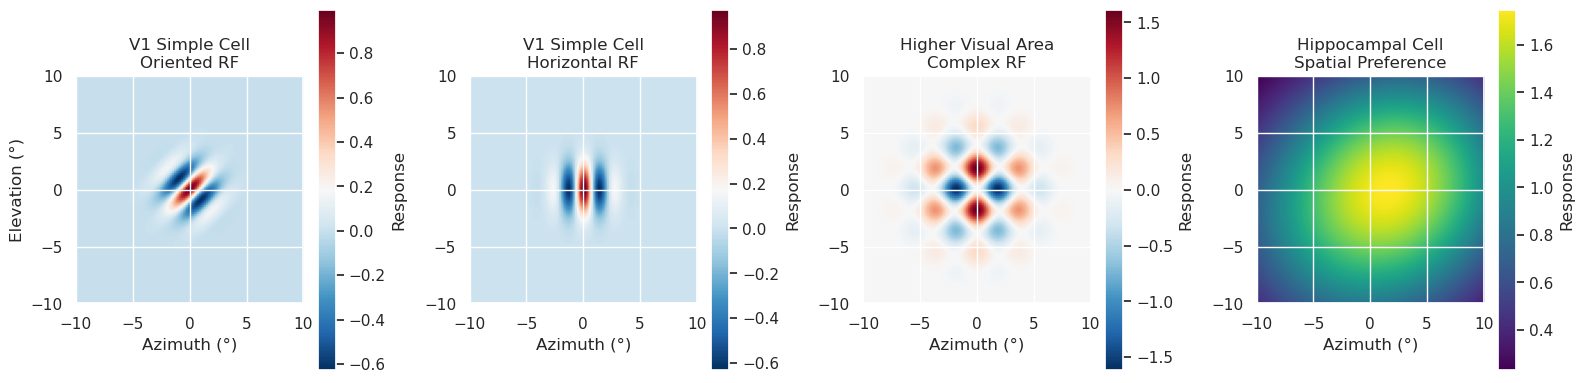

In [11]:
# Simulate receptive field mapping based on neural responses to moving bars
# Note: This is simulated data based on typical receptive field properties

# Create a visual space grid
visual_field_size = 100  # pixels
x_coords = np.linspace(-10, 10, visual_field_size)  # degrees
y_coords = np.linspace(-10, 10, visual_field_size)  # degrees
X, Y = np.meshgrid(x_coords, y_coords)

# Create receptive fields for different neuron types
# V1 simple cell - oriented Gabor filter
def gabor(x, y, sigma=1.0, theta=0, Lambda=2.0, psi=0, gamma=1.0):
    """Generate a Gabor filter."""
    sigma_x = sigma
    sigma_y = float(sigma) / gamma
    
    # Rotation
    x_theta = x * np.cos(theta) + y * np.sin(theta)
    y_theta = -x * np.sin(theta) + y * np.cos(theta)
    
    gb = np.exp(-.5 * (x_theta ** 2 / sigma_x ** 2 + y_theta ** 2 / sigma_y ** 2)) * np.cos(2 * np.pi * x_theta / Lambda + psi)
    return gb

# Create different receptive fields
v1_simple_rf = gabor(X, Y, sigma=1.5, theta=np.pi/4, Lambda=3)
v1_simple2_rf = gabor(X, Y, sigma=1.5, theta=0, Lambda=3)

# Higher visual area - larger, more complex RF
higher_rf1 = gabor(X, Y, sigma=3, theta=0, Lambda=4)
higher_rf2 = gabor(X, Y, sigma=3, theta=np.pi/2, Lambda=4)
higher_rf = higher_rf1 - higher_rf2  # Complex cell-like

# Hippocampal "receptive field" - less spatially specific
def radial_gradient(x, y, center_x, center_y, sigma=5.0):
    """Create a radial gradient centered at (center_x, center_y)."""
    return np.exp(-((x - center_x)**2 + (y - center_y)**2) / (2 * sigma**2))

hpc_rf = radial_gradient(X, Y, -2, 3, sigma=8) + radial_gradient(X, Y, 4, -2, sigma=7)

# Visualize the receptive fields
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# V1 Simple Cell
im0 = axes[0].imshow(v1_simple_rf, cmap='RdBu_r', extent=[-10, 10, -10, 10])
axes[0].set_title('V1 Simple Cell\nOriented RF')
axes[0].set_xlabel('Azimuth (°)')
axes[0].set_ylabel('Elevation (°)')
plt.colorbar(im0, ax=axes[0], label='Response')

# V1 Simple Cell with different orientation
im1 = axes[1].imshow(v1_simple2_rf, cmap='RdBu_r', extent=[-10, 10, -10, 10])
axes[1].set_title('V1 Simple Cell\nHorizontal RF')
axes[1].set_xlabel('Azimuth (°)')
plt.colorbar(im1, ax=axes[1], label='Response')

# Higher Visual Area Complex Cell
im2 = axes[2].imshow(higher_rf, cmap='RdBu_r', extent=[-10, 10, -10, 10])
axes[2].set_title('Higher Visual Area\nComplex RF')
axes[2].set_xlabel('Azimuth (°)')
plt.colorbar(im2, ax=axes[2], label='Response')

# Hippocampal "Receptive Field"
im3 = axes[3].imshow(hpc_rf, cmap='viridis', extent=[-10, 10, -10, 10])
axes[3].set_title('Hippocampal Cell\nSpatial Preference')
axes[3].set_xlabel('Azimuth (°)')
plt.colorbar(im3, ax=axes[3], label='Response')

plt.tight_layout()
plt.show()

## Neural Responses to Different Stimulus Types

The Vision2Hippocampus project aims to understand how neural responses evolve from simple feature detectors in early visual areas to more abstract representations in the hippocampus. Let's simulate what those differences might look like.

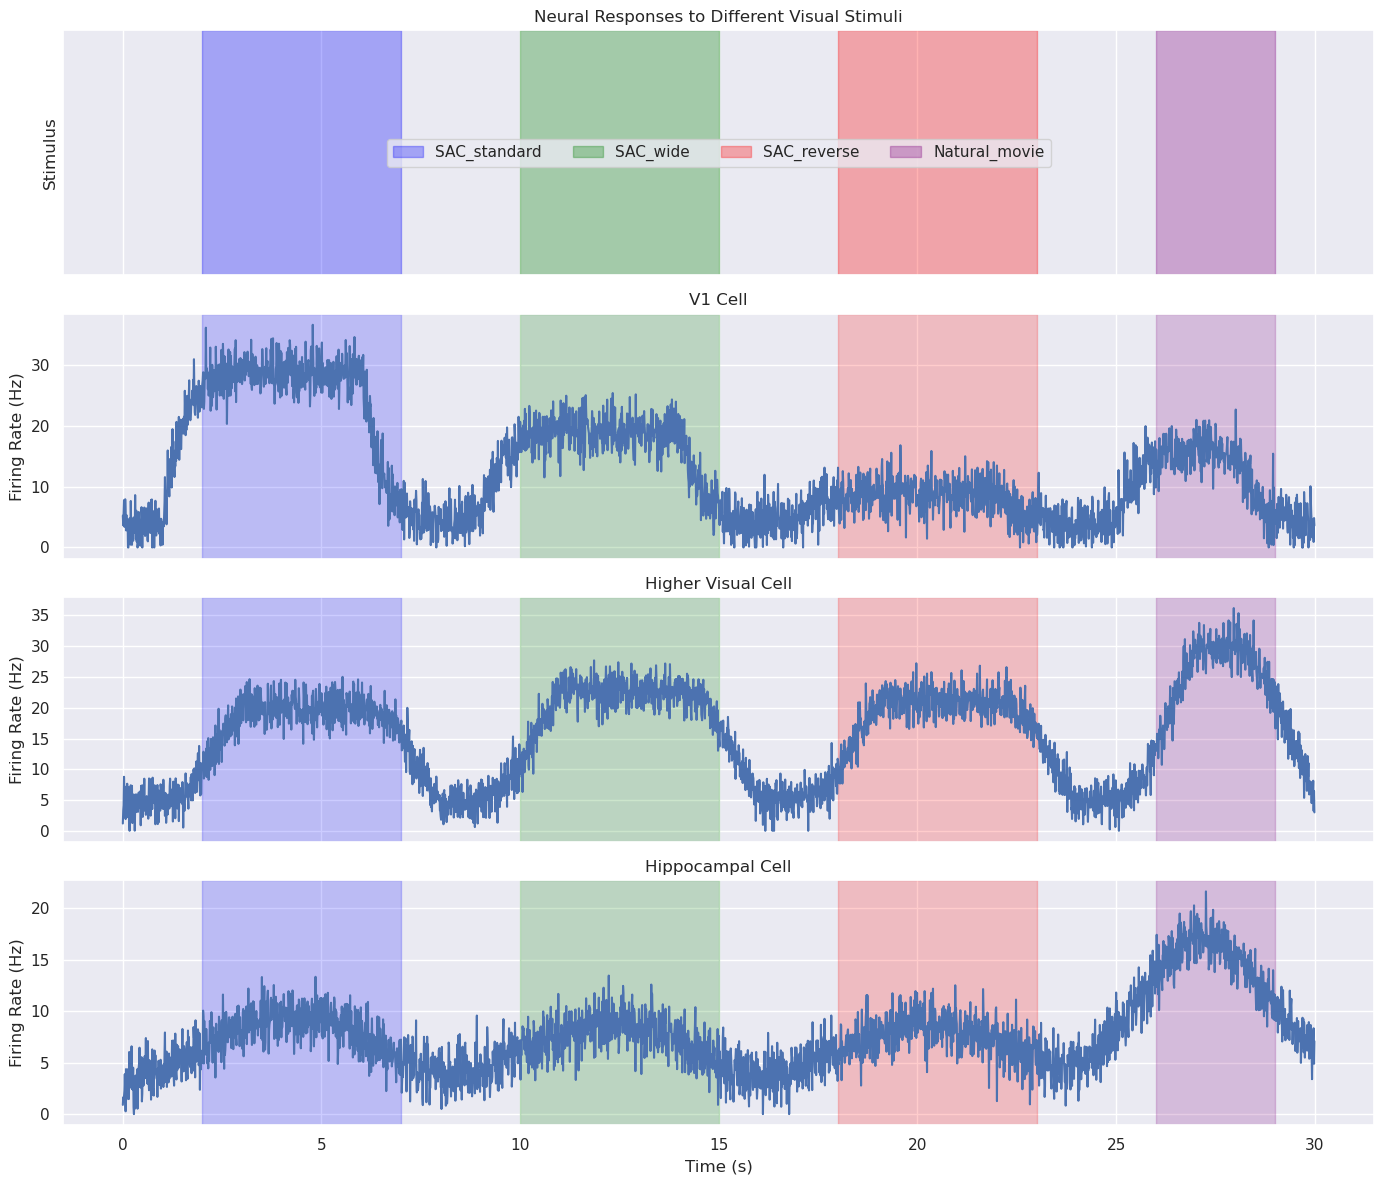

In [12]:
# Simulate responses of different neuron types to various stimuli
# Note: This is simulated data based on typical response properties

# Set up stimulus time and labels
stim_times = np.arange(0, 30, 0.01)
stim_types = ['SAC_standard', 'SAC_wide', 'SAC_reverse', 'Natural_movie']
stim_colors = ['blue', 'green', 'red', 'purple']

# Define stimulus presentation periods (s)
stim_periods = {
    'SAC_standard': (2, 7),
    'SAC_wide': (10, 15),
    'SAC_reverse': (18, 23),
    'Natural_movie': (26, 29)
}

# Create indicator functions for when each stimulus is on
stim_indicators = {}
for stim, (start, end) in stim_periods.items():
    indicator = np.zeros_like(stim_times)
    idx = (stim_times >= start) & (stim_times <= end)
    indicator[idx] = 1
    stim_indicators[stim] = indicator

# Create neural responses for different brain regions
response_types = {
    'V1 Cell': {
        'SAC_standard': 25,       # Strong response to preferred orientation
        'SAC_wide': 15,           # Weaker for wide bar (non-optimal width)
        'SAC_reverse': 5,         # Weak for opposite contrast
        'Natural_movie': 12       # Moderate for natural movies
    },
    'Higher Visual Cell': {
        'SAC_standard': 15,       # Moderate response to simple bars
        'SAC_wide': 18,           # Similar response to wider bar
        'SAC_reverse': 16,        # Similar response to reversed contrast
        'Natural_movie': 25       # Strong for natural scenes (more complex)
    },
    'Hippocampal Cell': {
        'SAC_standard': 8,        # Weak response to simple stimuli
        'SAC_wide': 7,            # Weak response to simple stimuli
        'SAC_reverse': 7,         # Weak response to simple stimuli
        'Natural_movie': 20       # Strong for natural scenes (more meaningful)
    }
}

# Generate neural responses to stimuli
np.random.seed(42)
responses = {}

for neuron, response_weights in response_types.items():
    # Base firing rate plus stimulus responses
    base_rate = {
        'V1 Cell': 4,
        'Higher Visual Cell': 5,
        'Hippocampal Cell': 2
    }[neuron]
    
    cell_response = np.ones_like(stim_times) * base_rate
    
    # Add responses to each stimulus type
    for stim, weight in response_weights.items():
        # Add weighted stimulus effect
        effect = stim_indicators[stim] * weight
        
        # Add temporal dynamics (different for each neuron type)
        if neuron == 'V1 Cell':
            # V1: Fast onset, slight adaptation
            kernel = np.exp(-np.arange(0, 2, 0.01) / 0.5)
            kernel = kernel / np.sum(kernel)
            effect = np.convolve(effect, kernel, mode='same')
        
        elif neuron == 'Higher Visual Cell':
            # Higher visual: Slower onset, sustained
            kernel = np.concatenate([np.linspace(0, 1, 100), np.ones(100)])
            kernel = kernel / np.sum(kernel)
            effect = np.convolve(effect, kernel, mode='same')
        
        elif neuron == 'Hippocampal Cell':
            # Hippocampus: Very slow onset, slow offset
            kernel = np.concatenate([np.linspace(0, 1, 200), np.ones(100), np.linspace(1, 0, 300)])
            kernel = kernel / np.sum(kernel)
            effect = np.convolve(effect, kernel, mode='same')
        
        cell_response += effect
    
    # Add noise
    noise_scale = {
        'V1 Cell': 2.5,
        'Higher Visual Cell': 2.0,
        'Hippocampal Cell': 1.5
    }[neuron]
    cell_response += np.random.normal(0, noise_scale, len(stim_times))
    
    # Ensure non-negative firing rates
    cell_response = np.maximum(0, cell_response)
    
    responses[neuron] = cell_response

# Visualize neural responses to different stimuli
fig, axes = plt.subplots(len(responses) + 1, 1, figsize=(14, 12), sharex=True)

# Plot stimulus timing
ax_stim = axes[0]
for i, (stim, (start, end)) in enumerate(stim_periods.items()):
    ax_stim.axvspan(start, end, alpha=0.3, color=stim_colors[i], label=stim)
ax_stim.set_ylabel('Stimulus')
ax_stim.set_yticks([])
ax_stim.legend(loc='center', ncol=len(stim_types))
ax_stim.set_title('Neural Responses to Different Visual Stimuli')

# Plot neural responses
for i, (neuron, response) in enumerate(responses.items(), 1):
    ax = axes[i]
    ax.plot(stim_times, response)
    ax.set_ylabel('Firing Rate (Hz)')
    ax.set_title(neuron)
    
    # Add stimulus markers
    for j, (stim, (start, end)) in enumerate(stim_periods.items()):
        ax.axvspan(start, end, alpha=0.2, color=stim_colors[j])

# Add x-axis label to bottom subplot
axes[-1].set_xlabel('Time (s)')

plt.tight_layout()
plt.show()

## Summary and Research Opportunities

The Allen Institute Openscope Vision2Hippocampus dataset (Dandiset 000690) provides a unique opportunity to study how visual information is transformed as it travels from early visual areas to higher cognitive regions.

### Dataset Structure Summary:

- **Total Files**: ~156 assets across ~25 recording sessions
- **Organization**: Main files, image files, and probe-specific electrophysiology files
- **Data Types**: LFP recordings, spike data, eye tracking, running measurements, stimulus metadata

### Key Research Questions This Dataset Can Address:

1. **Receptive Field Transformations**
   - How do receptive field properties change from V1 to hippocampus?
   - Does spatial selectivity decrease while feature abstraction increases?

2. **Parametric Stimulus Processing**
   - How do cortical vs. hippocampal neurons respond to systematic variations in stimulus properties?
   - Is there evidence of stimulus invariance in higher regions?

3. **Behavioral State Interactions**
   - How does running modulate visual representations across the hierarchy?
   - Does arousal (pupil size) affect different regions differently?

4. **Natural vs. Artificial Stimuli Processing**
   - Are hippocampal regions more selectively responsive to ethologically-relevant natural movies?
   - How does temporal integration differ between simple and complex stimuli?

### Analysis Approaches:

1. **Cross-Area Comparison**:
   ```python
   # Example pseudo-code for comparing responses across regions
   v1_responses = get_responses(area='V1', stimulus='standard_bar')
   hpc_responses = get_responses(area='hippocampus', stimulus='standard_bar')
   
   # Calculate key metrics
   response_latency = calculate_latency(v1_responses, hpc_responses)
   response_duration = calculate_duration(v1_responses, hpc_responses)
   selectivity_index = calculate_selectivity(v1_responses, hpc_responses)
   ```

2. **Stimulus Selectivity Analysis**:
   ```python
   # Example pseudo-code for analyzing parametric stimulus variations
   for stimulus_type in ['SAC_standard', 'SAC_wide', 'SAC_reverse', 'Natural_movie']:
       for region in ['V1', 'higher_visual', 'hippocampus']:
           responses = get_responses(region, stimulus_type)
           plot_tuning_curve(region, stimulus_type, responses)
   ```

3. **Behavioral Correlations**:
   ```python
   # Example pseudo-code for correlating neural responses with behavior
   running_speed = get_running_data(session_id)
   v1_activity = get_neural_data(region='V1', session_id=session_id)
   hpc_activity = get_neural_data(region='hippocampus', session_id=session_id)
   
   plot_correlation(running_speed, v1_activity, 'V1')
   plot_correlation(running_speed, hpc_activity, 'Hippocampus')
   ```

This dataset provides a rich resource for neuroscientists interested in visual processing, hierarchical information transformation, and the interface between sensory coding and cognitive representation.